# Clasificación de estrellas púlsares

Mediante el siguiente notebook se pretenden clasificar estrellas como púlsares y no púlsares, utilizando los datos obtenidos de https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star. Inicialmente se estandarizarán los datos, para que toda la información quede contenida en un rango entre -1 y 1. Luego se analizará el rendimiento del modelo mediante las métricas accuracy y matriz de confusión. Finalmente, se estudiará la generalización de la red neuronal a nivel global realizando una curva de aprendizaje con el tamaño de la muestra como su hiper-parámetro.

 
   
Los púlsares son un tipo raro de estrellas de neutrones que producen emisiones de radio que son detectables aquí en la Tierra. A medida que los púlsares giran, su haz de emisión recorre el cielo, y cuando cruza nuestra línea de visión, produce un patrón detectable de emisión de radio. A medida que los púlsares giran rápidamente, este patrón se repite periódicamente. Por lo tanto, la búsqueda de un púlsar implica buscar señales de radio periódicas con radiotelescopios muy grandes.

Cada púlsar produce un patrón de emisión ligeramente diferente, que varía levemente con cada rotación. Por lo tanto, una detección de señal potencial conocida como 'candidato' se promedia en muchas rotaciones del púlsar, según lo determinado por la duración de una observación. En ausencia de información adicional, cada candidato podría corresponder a un púlsar real. Sin embargo, en la práctica, casi todas las detecciones son causadas por interferencia de radiofrecuencia (RFI) y ruido, lo que hace que sea difícil encontrar señales legítimas.

El aprendizaje automático nos permite crear algoritmos que sean capaces de etiquetar automáticamente a los candidatos de pulsar, lo que facilitará y agilizará el análisis de los datos. En este ejercicio en particular los casos legítimos de púlsares son una clase positiva minoritaria (etiquetados como 1), y los ejemplos falsos son la clase negativa mayoritaria (etiquetados como 0). El conjunto de datos contiene 16,259 ejemplos negativos causados por RFI o ruido, y 1,639 ejemplos de púlsares reales, con lo que queda un total de 17,898 datos. Todos estos ejemplos han sido verificados por anotadores humanos.



## Obtención de datos

In [1]:
import numpy as np
import pandas as pd

#### Carga y visualización de los datos

In [2]:
data = pd.read_csv("pulsar_stars.csv")
#data = pd.read_csv("/home/anell/Projects/Pulsar-NN/pulsar_stars.csv")

Cada candidato se describe mediante 8 variables continuas y una variable de clase única. Las primeras cuatro características son estadísticas simples obtenidas del perfil de pulso integrado, que básicamente se basa en una versión de la señal promedida en tiempo y en frecuencia, esta versión corresponde a la intensidad percibida en función de la fase de la señal.Las cuatro variables restantes se obtienen de manera similar de la curva DM-SNR. Estos se visualizan a continuación:

In [3]:
data

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


In [32]:
data.groupby("target_class").size()

target_class
0    16259
1     1639
dtype: int64

In [4]:
data.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


## Estandarización de los datos

La estandarización de los datos puede mejorar rendimiento del algoritmo de clasificación, ya que localiza la información dentro de un rango acotado e igual para todas las características de cada dato. Para realizar este procedimiento, primero se debe obtener el promedio ($\mu_i$) y el rango de variación ($S_i$) de cada una de las columnas que describe a cada ejemplo. Luego, se debe redefinir cada columa de dato como:

$$ X_i = \frac{X_i - \mu_i}{S_i} $$

en donde el rango, $S_i$, se calcula restando los valores máximos con los mínimos de cada columna.

In [26]:
data_estand = data.copy()

promedios = (data.mean())[0:-1] #Descartamos el promedio de la columna target_class
rango = (data.max() - data.min())[0:-1] #Descarta el rengo de la columna target_class

In [23]:
promedios

 Mean of the integrated profile                  111.079968
 Standard deviation of the integrated profile     46.549532
 Excess kurtosis of the integrated profile         0.477857
 Skewness of the integrated profile                1.770279
 Mean of the DM-SNR curve                         12.614400
 Standard deviation of the DM-SNR curve           26.326515
 Excess kurtosis of the DM-SNR curve               8.303556
 Skewness of the DM-SNR curve                    104.857709
dtype: float64

In [24]:
rango

 Mean of the integrated profile                   186.804688
 Standard deviation of the integrated profile      74.006869
 Excess kurtosis of the integrated profile          9.945533
 Skewness of the integrated profile                69.893508
 Mean of the DM-SNR curve                         223.178930
 Standard deviation of the DM-SNR curve           103.271778
 Excess kurtosis of the DM-SNR curve               37.679114
 Skewness of the DM-SNR curve                    1192.977813
dtype: float64

In [25]:
promedios = promedios.values.tolist() #pasa de dataframe a lista
rango = rango.values.tolist()

In [27]:
for i in range(len(data)): #con esto redefinimos cada dato perteneciente a data_estand
    data_estand.iloc[i, 0:8] = data_estand.iloc[i, 0:8] - promedios
    data_estand.iloc[i, 0:8] = data_estand.iloc[i, 0:8].div(rango)

In [28]:
data_estand

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,0.157825,0.123424,-0.071633,-0.035338,-0.042184,-0.069875,-0.008706,-0.025663,0
1,-0.045888,0.166645,-0.001261,-0.032698,-0.049006,-0.111031,0.060323,0.018890,0
2,-0.043170,-0.097395,-0.015538,-0.010289,-0.042536,-0.044367,-0.015068,-0.034943,0
3,0.137416,0.143621,-0.054926,-0.034431,-0.040198,-0.051972,-0.037343,-0.042972,0
4,-0.119662,-0.079416,0.012368,-0.009254,-0.051239,-0.143871,0.158338,0.123816,0
...,...,...,...,...,...,...,...,...,...
17893,0.135702,0.179685,-0.066935,-0.035889,-0.050711,-0.137118,0.189673,0.151783,0
17894,0.061426,0.039673,-0.035180,-0.020706,0.017006,0.177206,-0.142209,-0.080941,0
17895,0.044196,0.180881,-0.032024,-0.035959,0.039503,0.315144,-0.154039,-0.084044,0
17896,0.018350,0.099354,-0.027821,-0.025683,-0.047800,-0.125347,0.045235,0.024628,0


In [33]:
data_estand.groupby("target_class").size()

target_class
0    16259
1     1639
dtype: int64

En el proceso de estandarización es importante no redefinir los datos de las etiquetas, para no generar ambiguedades o confusiones con los datos. 

## Red neuronal


In [34]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


#### Contrucción de la red neuronal

A continuación se crearán dos funciones. La primera de estas funciones recibe el número de características o columnas que describe a cada ejemplo, que en este ejercicio serían 8, y forma el modelo de la red neuronal a utilizar. La segunda función separá un conjunto de datos, recibido como input, en un set de entrenamiento y un set de validación, cuyos tamaños serán del 80% y 20% respectivamente, de un tamaño m entregado inicialmente.

In [37]:
def define_model(input_dim=8):
    inputs = Input(shape=(8,))

    x = Dense(2)(inputs)
    x = Activation("relu")(x)

    x = Dense(1)(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs, x)

    # Compilación del modelo:
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()
    
    return model


def train_valid(data, m):

    data = data.sample(frac=1)  

    data_train = data[:int(0.8*m)]
    data_valid = data[int(0.8*m):m]
    
    #train sample
    ejemplos_train = data_train.values.tolist()
    ejemplos_train = np.array(ejemplos_train)

    features_train = ejemplos_train.transpose()
    
    X_train = features_train[0:8]
    Y_train = features_train[8]

    X_train = X_train.transpose()
    
    #valid_sample
    ejemplos_valid = data_valid.values.tolist()
    ejemplos_valid = np.array(ejemplos_valid)

    features_valid = ejemplos_valid.transpose()
    
    X_valid = features_valid[0:8]
    Y_valid = features_valid[8]

    X_valid = X_valid.transpose()
    
    print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
    
    return X_train, Y_train, X_valid, Y_valid

## Evaluación del modelo: 
### Cálculo del error global mediante la métrica accuracy

Utilizando las funciones definidas anteriormente, se generarán dos sets de datos; uno de entrenamiento, cuyo tamaño corresponderá al 80% del total de 17898 datos y un set de validación cruzada (cv), cuyo tamaño corresponderá al 20%.

In [39]:
X_train_global, Y_train_global, X_cv_global, Y_cv_global = train_valid(data_est, len(data_estand))

(14318, 8) (14318,) (3580, 8) (3580,)


In [40]:
Global_model = define_model(8)

Global_model.fit(X_train_global,Y_train_global, epochs=20, batch_size=10)    

Epoch 1/20
14318/14318 [==============================] - 27s 2ms/step - loss: 2.2162 - accuracy: 0.8323
Epoch 2/20
14318/14318 [==============================] - 21s 1ms/step - loss: 0.2069 - accuracy: 0.9450
Epoch 3/20
14318/14318 [==============================] - 21s 1ms/step - loss: 0.1411 - accuracy: 0.9587
Epoch 4/20
14318/14318 [==============================] - 22s 2ms/step - loss: 0.1281 - accuracy: 0.9632
Epoch 5/20
14318/14318 [==============================] - 21s 1ms/step - loss: 0.1179 - accuracy: 0.9675
Epoch 6/20
14318/14318 [==============================] - 21s 1ms/step - loss: 0.1107 - accuracy: 0.9698
Epoch 7/20
14318/14318 [==============================] - 21s 1ms/step - loss: 0.1059 - accuracy: 0.9717
Epoch 8/20
14318/14318 [==============================] - 21s 1ms/step - loss: 0.1036 - accuracy: 0.9723
Epoch 9/20
14318/14318 [==============================] - 22s 2ms/step - loss: 0.0997 - accuracy: 0.9733
Epoch 10/20
14318/14318 [==============================

In [43]:
# calculamos el error global del modelo para el conjunto de entrenamiento
J_train, accuracy_train = Global_model.evaluate(X_train_global, Y_train_global)
print('Accuracy train: %.2f' % (accuracy_train*100))

14318/14318 [==============================] - 4s 274us/step
Accuracy train: 97.22


In [45]:
# evaluación del modelo para el conjunto de validación cruzada
J_cv, accuracy_cv = Global_model.evaluate(X_cv_global, Y_cv_global)
print('Accuracy CV: %.2f' % (accuracy_cv*100))

3580/3580 [==============================] - 1s 283us/step
Accuracy CV: 96.93


Con esto podemos notar que la precisión global, tanto para el conjunto de entrenamiento, como para el set de validación, es bastante alta. Sin embargo, esto no nos asegura que el modelo construido sea generalizable a más datos ni que sea el más óptimo. 

El hecho de que este modelo haya dado un accuracy tan alto para los dos sets de datos se debe principalmente a que, dentro del total de los datos, la cantidad de ceros, o casos negativos, es mucho mayor que la cantidad total de unos, o casos positivos, presentando una población de $~81\%$ y $~9\%$ respectivamente. Con esta gran diferencia si el algoritmo realiza una mala predicción, por ejemplo si predice que una estrella es pulsar, siendo que en realidad no lo es, esto no afectará en gran medida a la precisión ya que hay una gran cantidad de ceros que solventen el problema.

Otro factor que contribuyó a que este algoritmo presente una presición global alta, es que como los dos conjuntos de datos (de entrenamiento y de validación) fueron obtenidos a partir del mismo set o dominio, estos tenderán a presentar el mismo comportamiento, o uno muy similar, frente a un modelo de predicción.

Debido a esto, es más recomendable evaluar este modelo de clasificación utilizando una matríz de confusión.

### Evaluación del modelo utilizando la matriz de confusión

In [48]:
from sklearn.metrics import confusion_matrix

Las predicciones entregadas por la red neuronal serán:

In [46]:
prediccion_train = Global_model.predict(X_train_global) #sin aproximar
prediccion_final_train = [round(x[0]) for x in prediccion_train] #aproxima a 1 o a 0

prediccion_cv = Global_model.predict(X_cv_global) #sin aproximar
prediccion_final_cv = [round(x[0]) for x in prediccion_cv] #aproxima a 1 o a 0

Con esto podemos realizar la matriz de confusión, que en este ejemplo será una matriz de dimensión 2, ya que tenemos sólo dos posibles clases (0 y 1)

In [49]:
#Matriz de confusión para el set de entrenamiento
confusion_matrix(Y_train_global,prediccion_final_train)

array([[12876,   131],
       [  267,  1044]])

De la matriz de confusión del set de entrenamiento (tamaño igual a 14318) podemos ver que el modelo presentó 12876 verdaderos negativos (estrellas que no son púlsares las predice como no púlsares), 131 falsos positivos (estrellas que no son púlsares las predice como púlsares), 267 falsos negativos (estrellas que son púlsares las predice como no púlsares) y 1044 verdaderos positivos (estrella púlsares las predice como púlsares)

In [50]:
#Matriz de confusión para el set de validación cruzada
confusion_matrix(Y_cv_global,prediccion_final_cv)

array([[3214,   38],
       [  72,  256]])

De la matriz de confusión del set de validación (tamaño igual a 3580) podemos ver que el modelo presentó 3214 verdaderos negativos (estrellas que no son púlsares las predice como no púlsares), 38 falsos positivos (estrellas que no son púlsares las predice como púlsares), 72 falsos negativos (estrellas que son púlsares las predice como no púlsares) y 256 verdaderos positivos (estrella púlsares las predice como púlsares)

En general, podemos decir que la precisión global del modelo es alta, presentando un 97.22% de precisión para el set de entrenamiento y un 96.92% para el set de validación cruzada. Sin embargo, mediante la utilización de las matrices de confusión notamos que la tasa de identificación de pulsares es baja, para el set de entrenamiento esta tasa resultó ser 1044/(1044+256) = 0.8 y para el set de validación fue 256/(256+72) = 0.78.

# Curva de aprendizaje

Realizaremos una curva de aprendizaje cuyo hiper-parámetro será el tamaño de la muestra. Esta curva, nos permitirá analizar la cantidad de datos que son suficientes para lograr un rendimiento global óptimo del modelo.

In [51]:
import matplotlib.pyplot as plt

Realizaremos una lista con distintos tamaños de muestra, en donde cada uno de estos será utilizado para crear un modelo que luego será evaluado para los sets de datos creados. Cabe notar que los números escogidos en la lista de los tamaños que se utilizarán presentan un crecimiento aproximadamente exponencial, esto se escogió así para visualizar de manera significante los cambios en la curva de aprendizaje.

In [55]:
lista_m = [400,800,1600,3200,6400,12800,len(data_est)]

lista_Jtrain = []
lista_Jcv = []

lista_acc_train = []
lista_acc_cv = []

for m in lista_m:
    
    X_train, Y_train, X_cv, Y_cv = train_valid(data_estand, m)
  
    #restart the model
    model = define_model(8)

    #train the model
    model.fit(X_train,Y_train, epochs=20, batch_size=10)
    
    Jtrain, accuracy_train = model.evaluate(X_train, Y_train)
    
    Jcv, accuracy_cv = model.evaluate(X_cv, Y_cv)
    
    lista_Jtrain.append(Jtrain)
    lista_Jcv.append(Jcv)
    
    lista_acc_train.append(accuracy_train)
    lista_acc_cv.append(accuracy_cv)
    
    print(m, Jtrain, accuracy_train, Jcv, accuracy_cv)

(320, 8) (320,) (80, 8) (80,)
Epoch 1/20
320/320 [==============================] - 8s 23ms/step - loss: 0.7148 - accuracy: 0.2531
Epoch 2/20
320/320 [==============================] - 0s 1ms/step - loss: 0.6853 - accuracy: 0.5625
Epoch 3/20
320/320 [==============================] - 0s 1ms/step - loss: 0.6623 - accuracy: 0.9031
Epoch 4/20
320/320 [==============================] - 1s 2ms/step - loss: 0.6445 - accuracy: 0.9719
Epoch 5/20
320/320 [==============================] - 0s 1ms/step - loss: 0.6302 - accuracy: 0.9750
Epoch 6/20
320/320 [==============================] - 0s 1ms/step - loss: 0.6171 - accuracy: 0.9781
Epoch 7/20
320/320 [==============================] - 1s 2ms/step - loss: 0.6050 - accuracy: 0.9812
Epoch 8/20
320/320 [==============================] - 0s 1ms/step - loss: 0.5932 - accuracy: 0.9844
Epoch 9/20
320/320 [==============================] - 1s 2ms/step - loss: 0.5819 - accuracy: 0.9781
Epoch 10/20
320/320 [==============================] - 0s 1ms/step - 

### Visualización curva de aprendizaje

In [53]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Costo')

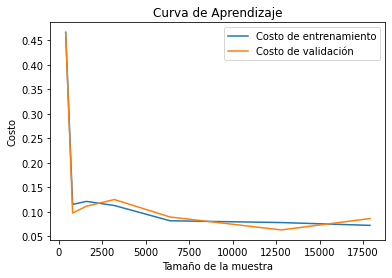

In [57]:
plt.plot(lista_m,lista_Jtrain, label = "Costo de entrenamiento")
plt.plot(lista_m,lista_Jcv,label = "Costo de validación")
plt.legend()
plt.title("Curva de Aprendizaje")
plt.xlabel("Tamaño de la muestra")
plt.ylabel("Costo")

A partir de la curva de aprendizaje podemos notar que el error global de entrenamiento y de validación cruzada presentan un comportamiento bastante similar. Además, es posible concluir que la cantidad mínima u óptima de datos que se pueden utilizar en este problema es m = 10000, ya que en torno a este número, los errores se muestran bastante reducidos y estables.